In [ ]:
import sys
from src import FEFF
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from scipy import interpolate
import matplotlib.colors as colors
from scipy import ndimage

Welcome to JupyROOT 6.30/08


In [2]:
modes = ["EXAFS", 'XANES']
edges = ['L1','L2','L3']
# top_dir = '/media/ata/HDD/PhD_data/feff_core_hole'
top_dir = '/media/ata/HDD/PhD_data/feff_core_hole_35atom'

momentum = np.round(np.arange(0.1,20,0.02),2)
config = FEFF.simulation_config(modes,edges,momentum,top_dir,compton=True)
xsection = FEFF.build_xsection(config)    

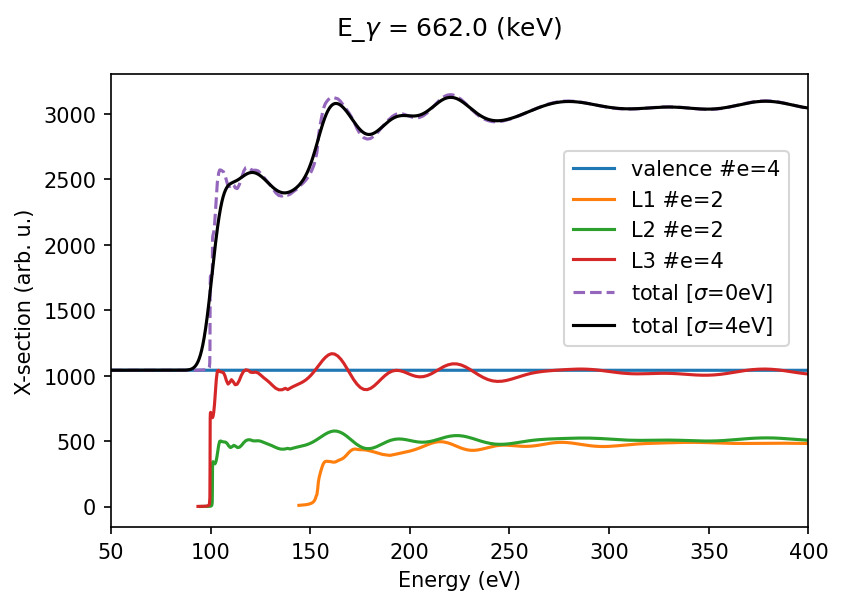

In [3]:
electron_count = dict(L3=4, L2=2, L1=2,valence=4)
plt.figure(dpi = 150)
primary_energies = 662_000 # energy of the incoming gammas!


y_total = 0
# how to discretize the cross section.
bins_width = 0.1
e_total = np.round(np.arange(50,1000,bins_width),2)
for shell in ['valence','L1','L2','L3']:
    energy, integrand = xsection.get_1d_integrand_new(primary_energies,shell)
    plt.plot(energy,integrand*1e11*620,label=f'{shell} #e={electron_count[shell]}')
    y_total+=np.interp(e_total,energy, integrand,left=0,right=0)

plt.plot(e_total,y_total*1e11*620,linestyle = '--',label='total [$\sigma$=0eV]')

smearing = 4 #eV
smeard_integral = ndimage.gaussian_filter(y_total,smearing/bins_width)
plt.plot(e_total,smeard_integral*1e11*620,c='k',label=f'total [$\sigma$={smearing}eV]')

plt.xlabel('Energy (eV)')
plt.ylabel('X-section (arb. u.)')
plt.xlim(50,400)
# plt.ylim(0,4000)
plt.suptitle(f'E_$\gamma$ = {primary_energies/1000} (keV)')
plt.legend(loc=(0.65,0.4))

# plt.savefig('FEFF_RPA.png', bbox_inches='tight', facecolor='white')
plt.savefig('FEFF_RPA_35_atom.png', bbox_inches='tight', facecolor='white')

In [5]:
# save the total cross section to the np file!
# np.savez('core_hole.npz',energy=e_total, x_section=y_total)
np.savez('core_hole_35atom.npz',energy=e_total, x_section=y_total)

In [6]:
modes = ["EXAFS", 'XANES']
edges = ['L1','L2','L3']
top_dir = '/media/ata/HDD/PhD_data/feff_no_core_hole/'

momentum = np.round(np.arange(0.1,20,0.02),2)
config = FEFF.simulation_config(modes,edges,momentum,top_dir,compton=True)
xsection = FEFF.build_xsection(config)    

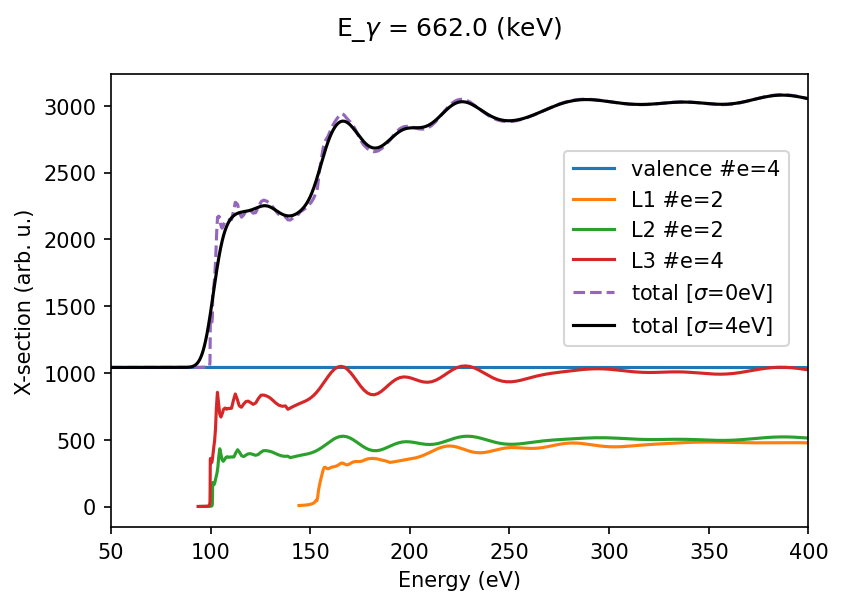

In [7]:
electron_count = dict(L3=4, L2=2, L1=2,valence=4)
plt.figure(dpi = 150)
primary_energies = 662_000

y_total = 0
# how to discretize the cross section.
bins_width = 0.1
e_total = np.round(np.arange(50,1000,bins_width),2)
for shell in ['valence','L1','L2','L3']:
    energy, integrand = xsection.get_1d_integrand_new(primary_energies,shell)
    plt.plot(energy,integrand*1e11*620,label=f'{shell} #e={electron_count[shell]}')
    y_total+=np.interp(e_total,energy, integrand,left=0,right=0)

plt.plot(e_total,y_total*1e11*620,linestyle = '--',label='total [$\sigma$=0eV]')

smearing = 4 #eV
smeard_integral = ndimage.gaussian_filter(y_total,smearing/bins_width)
plt.plot(e_total,smeard_integral*1e11*620,c='k',label=f'total [$\sigma$={smearing}eV]')

plt.xlabel('Energy (eV)')
plt.ylabel('X-section (arb. u.)')
plt.xlim(50,400)
# plt.ylim(0,4000)
plt.suptitle(f'E_$\gamma$ = {primary_energies/1000} (keV)')
plt.legend(loc=(0.65,0.4))

plt.savefig('FEFF_no_corehole.png', bbox_inches='tight', facecolor='white')

In [8]:
# save the total cross section to the np file!
np.savez('no_core_hole.npz',energy=e_total, x_section=y_total)

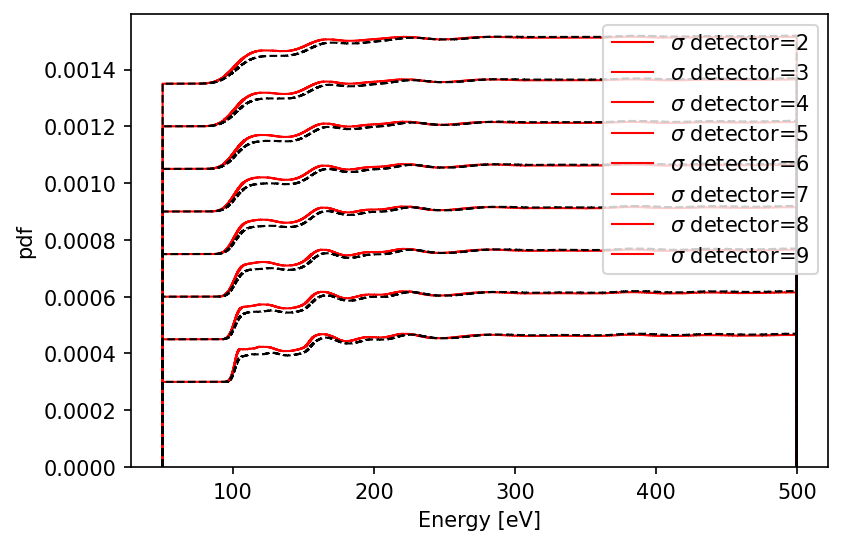

In [9]:
def smear_spectrum(energy,spectrum,resolution):
    bin_width = energy[1]-energy[0] # in [eV]
    smeard_spectrum = ndimage.gaussian_filter(spectrum,resolution/bin_width)
    return energy,smeard_spectrum
def make_data_hists(ax, x_main,y_main, arange_resolution=(2,10,1),linestyle='--',color ='k',if_legend= True):
    data_hists = {}
    
    for res in np.arange(*arange_resolution):
        x,y = smear_spectrum(x_main,y_main,res)
        energy_mask = (50<=x) & (x<=500)
        x = np.array(x,dtype='double')[energy_mask]
        y = np.array(y,dtype='double')[energy_mask]
        x_edge = (x[1:]+x[:-1])/2
        y_centers = y[1:-1]
        pdf = y_centers/np.sum(y_centers)
        ax.stairs(pdf-min(pdf)+res*0.00015,x_edge,linestyle=linestyle,color=color,label = f'$\sigma$ detector={res}')
        data_hists[res] = [pdf,x_edge]
    ax.set_xlabel('Energy [eV]')
    ax.set_ylabel('pdf')
    if if_legend:
        ax.legend()
    return data_hists

core_hole_data = np.load('../FEFF/core_hole.npz')
no_core_hole_data = np.load('../FEFF/no_core_hole.npz')

fig,ax = plt.subplots(dpi = 150)
x_main,y_main = core_hole_data['energy'], core_hole_data['x_section']
data_hists_core_hole = make_data_hists(ax,x_main,y_main, linestyle='-',color = 'r',arange_resolution=(2,10,1),)
x_main,y_main = no_core_hole_data['energy'], no_core_hole_data['x_section']
data_hists_no_core_hole = make_data_hists(ax,x_main,y_main, arange_resolution=(2,10,1),if_legend = False)